In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import cv2
import numpy as np


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG19,MobileNetV3Small,ResNet50,DenseNet121,EfficientNetB7
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import keras
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
#from pretty_confusion_matrix import pp_matrix
#confusion_matrix = metrics.confusion_matrix(y_true=y_test_labels, y_pred=pred_labels)  # shape=(12, 12)
from sklearn.metrics import confusion_matrix

In [ ]:
classes=[]
filename='/content/drive/MyDrive/hey'
for sub_folder in os.listdir(os.path.join(filename,'Training')):
    classes.append(sub_folder)
print(classes)

['pituitary', 'meningioma', 'notumor', 'glioma']


In [ ]:
#resize images and put together Training and Testing folder

X_train = []
y_train = []
image_size = 160
for i in classes:
    path_train = os.path.join(filename,'Training',i)
    for j in tqdm(os.listdir(path_train)): #Instantly make your loops show a smart progress meter 
        img = cv2.imread(os.path.join(path_train,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
    path_test = os.path.join(filename,'Testing',i)
    for j in tqdm(os.listdir(path_test)):
        img = cv2.imread(os.path.join(path_test,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 400/400 [00:06<00:00, 64.45it/s] 


In [ ]:
#data augmentation
X_train, y_train = shuffle(X_train,y_train, random_state=42)
datagen = ImageDataGenerator(
    rotation_range=7, #rotate images
    width_shift_range=0.05,
    height_shift_range=0.05, #shift image in horizontal and vertical
    zoom_range=0.1, #zoom images
    horizontal_flip=True)

datagen.fit(X_train)
X_train.shape
lb = LabelEncoder()

#train and test splitting 
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.15,random_state=42,stratify=y_train)

labels_train=lb.fit(y_train)
y_train=lb.transform(y_train)
y_test=lb.transform(y_test)

In [ ]:
print(y_train)

#load EfficientNet
EfficientNet1=VGG19(weights='imagenet',include_top=False)
EfficientNet2=MobileNetV3Small(weights='imagenet',include_top=False)
EfficientNet3=ResNet50(weights='imagenet',include_top=False)
EfficientNet4=DenseNet121(weights='imagenet',include_top=False)
EfficientNet5=EfficientNetB7(weights='imagenet',include_top=False)

[2 1 0 ... 1 3 0]
80134624/80134624 [==============================] - 0s 0us/step


258076736/258076736 [==============================] - 2s 0us/step


In [ ]:
#train the model
tf.random.set_seed(45)
model1 = EfficientNet1.output
model1 = tf.keras.layers.GlobalAveragePooling2D()(model1)
model1 = tf.keras.layers.Dropout(rate=0.55)(model1)
model1 = tf.keras.layers.Dense(60,activation='elu',kernel_initializer='GlorotNormal')(model1)
model1 = tf.keras.layers.Dropout(rate=0.3)(model1)
model1 = tf.keras.layers.Dense(4,activation='softmax')(model1)
model1 = tf.keras.models.Model(inputs=EfficientNet1.input, outputs = model1)
opt = Adam(
    learning_rate=0.000016, beta_1=0.91, beta_2=0.9994,
    epsilon=1e-08)

model1.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

# summarize the model
print(model1.summary())
# fit the model
early_stopping_cb=keras.callbacks.EarlyStopping(patience=9,restore_best_weights=True)


history1=model1.fit(X_train ,y_train,validation_data = (X_test,y_test),epochs=5,
    batch_size=13,callbacks=early_stopping_cb)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
model1.save("vgg19.h5")

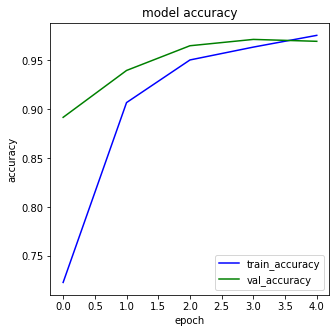

In [ ]:
plt.figure(figsize=(5,5))
# summarize history for accuracy
hist=history1.history
plt.plot(hist["accuracy"],color="b",label="train_accuracy")
plt.plot(hist["val_accuracy"],color="g",label="val_accuracy")
plt.title('model accuracy')
plt.ylabel('accuracy')  g
plt.xlabel('epoch')
plt.legend(loc="lower right")
plt.show()

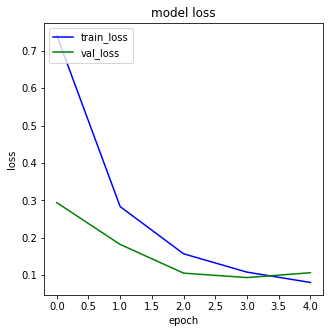

In [ ]:
plt.figure(figsize=(5,5))
# summarize history for loss
plt.plot(hist['loss'],color="b",label="train_loss")
plt.plot(hist['val_loss'],color="g",label="val_loss")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend( loc='upper left')
plt.show()

In [ ]:
loss, accuracy1 = model1.evaluate(X_test,y_test)

print('Accuracy: %f' % (accuracy1*100))

49/49 [==============================] - 8s 117ms/step - loss: 0.1066 - accuracy: 0.9696
Accuracy: 96.957928


In [ ]:
y_test_labels=lb.inverse_transform(y_test)

#predicted values
pred=np.argmax(model1.predict(X_test),axis=1)
pred_labels=lb.inverse_transform(pred) #predicted labels

49/49 [==============================] - 5s 96ms/step


In [ ]:
print(classification_report(y_test,pred,target_names=classes))

              precision    recall  f1-score   support

   pituitary       0.94      0.98      0.96       382
  meningioma       0.99      0.91      0.94       388
     notumor       0.99      1.00      0.99       375
      glioma       0.97      1.00      0.98       400

    accuracy                           0.97      1545
   macro avg       0.97      0.97      0.97      1545
weighted avg       0.97      0.97      0.97      1545



In [ ]:
#train the model
tf.random.set_seed(45)
model2 = EfficientNet2.output
model2 = tf.keras.layers.GlobalAveragePooling2D()(model2)
model2 = tf.keras.layers.Dropout(rate=0.55)(model2)
model2 = tf.keras.layers.Dense(60,activation='elu',kernel_initializer='GlorotNormal')(model2)
model2 = tf.keras.layers.Dropout(rate=0.3)(model2)
model2 = tf.keras.layers.Dense(4,activation='softmax')(model2)
model2 = tf.keras.models.Model(inputs=EfficientNet2.input, outputs = model2)
opt = Adam(
    learning_rate=0.000016, beta_1=0.91, beta_2=0.9994,
    epsilon=1e-08)

model2.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

# summarize the model
print(model2.summary())
# fit the model
early_stopping_cb=keras.callbacks.EarlyStopping(patience=9,restore_best_weights=True)


history2=model2.fit(X_train ,y_train,validation_data = (X_test,y_test),epochs=5,
    batch_size=13,callbacks=early_stopping_cb)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 Conv (Conv2D)                  (None, None, None,   432         ['rescaling[0][0]']              
                                16)                                                         

In [ ]:
model2.save("mobilenet.h5")

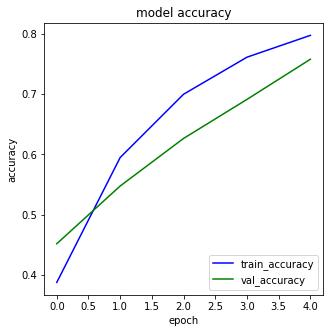

In [ ]:
plt.figure(figsize=(5,5))
# summarize history for accuracy
hist=history2.history
plt.plot(hist["accuracy"],color="b",label="train_accuracy")
plt.plot(hist["val_accuracy"],color="g",label="val_accuracy")
plt.title('model accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend(loc="lower right")
plt.show()

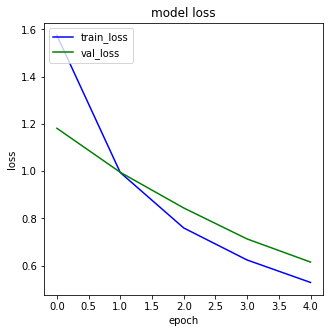

In [ ]:
plt.figure(figsize=(5,5))
# summarize history for loss
plt.plot(hist['loss'],color="b",label="train_loss")
plt.plot(hist['val_loss'],color="g",label="val_loss")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend( loc='upper left')
plt.show()

In [ ]:
loss, accuracy2 = model2.evaluate(X_test,y_test)

print('Accuracy: %f' % (accuracy2*100))

49/49 [==============================] - 1s 18ms/step - loss: 0.6157 - accuracy: 0.7579
Accuracy: 75.792879


In [ ]:
y_test_labels=lb.inverse_transform(y_test)

#predicted values
pred=np.argmax(model2.predict(X_test),axis=1)
pred_labels=lb.inverse_transform(pred) #predicted labels

49/49 [==============================] - 1s 12ms/step


In [ ]:
print(classification_report(y_test,pred,target_names=classes))

              precision    recall  f1-score   support

   pituitary       0.70      0.85      0.77       382
  meningioma       0.69      0.48      0.57       388
     notumor       0.74      0.99      0.85       375
      glioma       0.92      0.72      0.81       400

    accuracy                           0.76      1545
   macro avg       0.76      0.76      0.75      1545
weighted avg       0.77      0.76      0.75      1545



In [ ]:
#train the model
tf.random.set_seed(45)
model3 = EfficientNet3.output
model3 = tf.keras.layers.GlobalAveragePooling2D()(model3)
model3 = tf.keras.layers.Dropout(rate=0.55)(model3)
model3 = tf.keras.layers.Dense(60,activation='elu',kernel_initializer='GlorotNormal')(model3)
model3 = tf.keras.layers.Dropout(rate=0.3)(model3)
model3 = tf.keras.layers.Dense(4,activation='softmax')(model3)
model3 = tf.keras.models.Model(inputs=EfficientNet3.input, outputs = model3)
opt = Adam(
    learning_rate=0.000016, beta_1=0.91, beta_2=0.9994,
    epsilon=1e-08)

model3.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

# summarize the model
print(model3.summary())
# fit the model
early_stopping_cb=keras.callbacks.EarlyStopping(patience=9,restore_best_weights=True)


history3=model3.fit(X_train ,y_train,validation_data = (X_test,y_test),epochs=5,
    batch_size=13,callbacks=early_stopping_cb)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                         

In [ ]:
model3.save("res.h5")

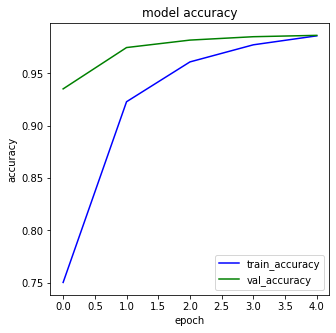

In [ ]:
plt.figure(figsize=(5,5))
# summarize history for accuracy
hist=history3.history
plt.plot(hist["accuracy"],color="b",label="train_accuracy")
plt.plot(hist["val_accuracy"],color="g",label="val_accuracy")
plt.title('model accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend(loc="lower right")
plt.show()

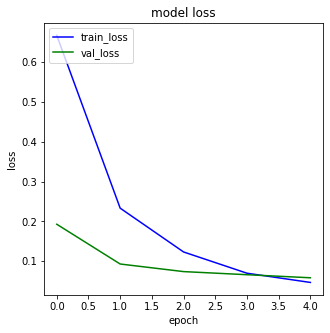

In [ ]:
plt.figure(figsize=(5,5))
# summarize history for loss
plt.plot(hist['loss'],color="b",label="train_loss")
plt.plot(hist['val_loss'],color="g",label="val_loss")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend( loc='upper left')
plt.show()

In [ ]:
loss, accuracy3 = model3.evaluate(X_test,y_test)

print('Accuracy: %f' % (accuracy3*100))

49/49 [==============================] - 4s 64ms/step - loss: 0.0584 - accuracy: 0.9864
Accuracy: 98.640776


In [ ]:
y_test_labels=lb.inverse_transform(y_test)

#predicted values
pred=np.argmax(model3.predict(X_test),axis=1)
pred_labels=lb.inverse_transform(pred) #predicted labels

49/49 [==============================] - 4s 53ms/step


In [ ]:
print(classification_report(y_test,pred,target_names=classes))

              precision    recall  f1-score   support

   pituitary       0.99      0.97      0.98       382
  meningioma       0.97      0.98      0.98       388
     notumor       0.99      1.00      0.99       375
      glioma       0.99      0.99      0.99       400

    accuracy                           0.99      1545
   macro avg       0.99      0.99      0.99      1545
weighted avg       0.99      0.99      0.99      1545



In [ ]:
#train the model
tf.random.set_seed(45)
model4 = EfficientNet4.output
model4 = tf.keras.layers.GlobalAveragePooling2D()(model4)
model4 = tf.keras.layers.Dropout(rate=0.55)(model4)
model4 = tf.keras.layers.Dense(60,activation='elu',kernel_initializer='GlorotNormal')(model4)
model4 = tf.keras.layers.Dropout(rate=0.3)(model4)
model4 = tf.keras.layers.Dense(4,activation='softmax')(model4)
model4 = tf.keras.models.Model(inputs=EfficientNet4.input, outputs = model4)
opt = Adam(
    learning_rate=0.000016, beta_1=0.91, beta_2=0.9994,
    epsilon=1e-08)

model4.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

# summarize the model
print(model4.summary())
# fit the model
early_stopping_cb=keras.callbacks.EarlyStopping(patience=9,restore_best_weights=True)


history4=model4.fit(X_train ,y_train,validation_data = (X_test,y_test),epochs=5,
    batch_size=13,callbacks=early_stopping_cb)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_4[0][0]']                
                                3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d[0][0]']         
                                64)                                                         

In [ ]:
model4.save("dense.h5")

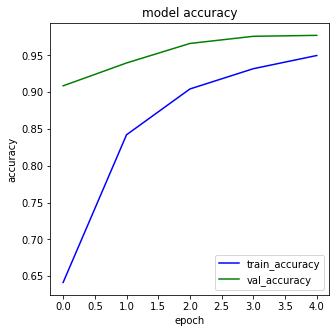

In [ ]:
plt.figure(figsize=(5,5))
# summarize history for accuracy
hist=history4.history
plt.plot(hist["accuracy"],color="b",label="train_accuracy")
plt.plot(hist["val_accuracy"],color="g",label="val_accuracy")
plt.title('model accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend(loc="lower right")
plt.show()

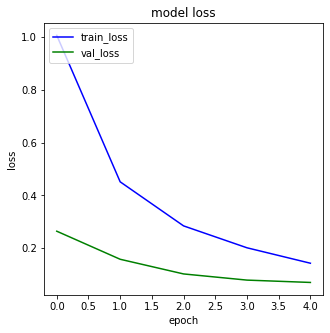

In [ ]:
plt.figure(figsize=(5,5))
# summarize history for loss
plt.plot(hist['loss'],color="b",label="train_loss")
plt.plot(hist['val_loss'],color="g",label="val_loss")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend( loc='upper left')
plt.show()

In [ ]:
loss, accuracy4 = model4.evaluate(X_test,y_test)

print('Accuracy: %f' % (accuracy4*100))

49/49 [==============================] - 5s 75ms/step - loss: 0.0706 - accuracy: 0.9773
Accuracy: 97.734630


In [ ]:
y_test_labels=lb.inverse_transform(y_test)

#predicted values
pred=np.argmax(model4.predict(X_test),axis=1)
pred_labels=lb.inverse_transform(pred) #predicted labels

49/49 [==============================] - 4s 51ms/step


In [ ]:
print(classification_report(y_test,pred,target_names=classes))

              precision    recall  f1-score   support

   pituitary       0.98      0.96      0.97       382
  meningioma       0.96      0.97      0.97       388
     notumor       0.98      1.00      0.99       375
      glioma       0.98      0.99      0.98       400

    accuracy                           0.98      1545
   macro avg       0.98      0.98      0.98      1545
weighted avg       0.98      0.98      0.98      1545



In [ ]:
#train the model
tf.random.set_seed(45)
model5 = EfficientNet5.output
model5 = tf.keras.layers.GlobalAveragePooling2D()(model5)
model5 = tf.keras.layers.Dropout(rate=0.55)(model5)
model5 = tf.keras.layers.Dense(60,activation='elu',kernel_initializer='GlorotNormal')(model5)
model5 = tf.keras.layers.Dropout(rate=0.3)(model5)
model5 = tf.keras.layers.Dense(4,activation='softmax')(model5)
model5 = tf.keras.models.Model(inputs=EfficientNet5.input, outputs = model5)
opt = Adam(
    learning_rate=0.000016, beta_1=0.91, beta_2=0.9994,
    epsilon=1e-08)

model5.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

# summarize the model
print(model5.summary())
# fit the model
early_stopping_cb=keras.callbacks.EarlyStopping(patience=9,restore_best_weights=True)


history5=model5.fit(X_train ,y_train,validation_data = (X_test,y_test),epochs=5,
    batch_size=13,callbacks=early_stopping_cb)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_1 (Rescaling)        (None, None, None,   0           ['input_5[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling_1[0][0]']            
                                3)                                                          

In [ ]:
model5.save("eff.h5")

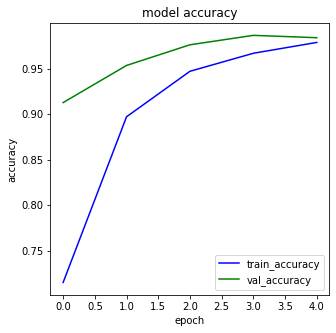

In [ ]:
plt.figure(figsize=(5,5))
# summarize history for accuracy
hist=history5.history
plt.plot(hist["accuracy"],color="b",label="train_accuracy")
plt.plot(hist["val_accuracy"],color="g",label="val_accuracy")
plt.title('model accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend(loc="lower right")
plt.show()

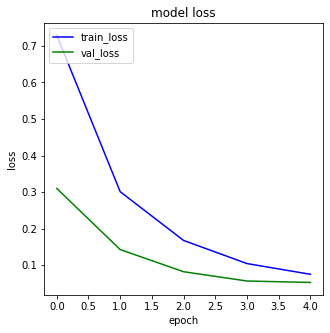

In [ ]:
plt.figure(figsize=(5,5))
# summarize history for loss
plt.plot(hist['loss'],color="b",label="train_loss")
plt.plot(hist['val_loss'],color="g",label="val_loss")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend( loc='upper left')
plt.show()

In [ ]:
loss, accuracy5 = model5.evaluate(X_test,y_test)

print('Accuracy: %f' % (accuracy5*100))

49/49 [==============================] - 12s 217ms/step - loss: 0.0530 - accuracy: 0.9838
Accuracy: 98.381877


In [ ]:
y_test_labels=lb.inverse_transform(y_test)

#predicted values
pred=np.argmax(model5.predict(X_test),axis=1)
pred_labels=lb.inverse_transform(pred) #predicted labels

49/49 [==============================] - 14s 195ms/step


In [ ]:
print(classification_report(y_test,pred,target_names=classes))

              precision    recall  f1-score   support

   pituitary       1.00      0.96      0.98       382
  meningioma       0.96      0.99      0.97       388
     notumor       0.99      1.00      1.00       375
      glioma       0.99      0.99      0.99       400

    accuracy                           0.98      1545
   macro avg       0.98      0.98      0.98      1545
weighted avg       0.98      0.98      0.98      1545



In [ ]:
predicted = model1.predict(X_test)
predicted[9]
# pituitary
# meningioma
# no tumor
# glioma

In [ ]:
plt.matshow(X_test[9])

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=7, #rotate images
    width_shift_range=0.05,
    height_shift_range=0.05, #shift image in horizontal and vertical
    zoom_range=0.1, #zoom images
    horizontal_flip=True)


X_train[0].shape 

import cv2
import os

x = X_train[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 




plt.imshow(X_train[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
name = ['Training=8582 MRI images', 'Testing=1705 MRI images']
people = [8582,1705]
myexplode = [0.1, 0.1]
plt.pie(people, labels=name, counterclock=False ,explode=myexplode,autopct='%0.f%%', shadow=True, startangle=90)


In [ ]:
import matplotlib.pyplot as plt
name = [  'glioma=400 MRI images' ,'meningioma=421 MRI images','notumor=510 MRI images','pituitary=374 MRI images']
people = [400,421,510,374]
myexplode = [0.1, 0.1, 0, 0.1]
plt.pie(people, labels=name, counterclock=False ,explode=myexplode,autopct='%0.f%%', shadow=True, startangle=90)